# Dogs Vs. Cats: Training a Covnet Using a Pretrained Model 

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np 
import matplotlib.pyplot as plt 

In [ ]:
# In order to download from Kaggle, we need to provide our authenticaion JSON file. 

from google.colab import files
files.upload()

In [3]:
# Create the directory that Kaggle checks for the authentication key, move the JSON file to the proper location
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Set permissions on the key
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [4]:
# Download the dataset from Kaggle, then unzip it. 
!kaggle competitions download -c dogs-vs-cats
# Note that Google Colab uses an outdated Kaggle API (1.5.4) so the file downloaded is different.
!unzip -q train.zip
!rm train.zip

  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 27.9MB/s]
 98% 532M/543M [00:02<00:00, 208MB/s]
100% 543M/543M [00:02<00:00, 230MB/s]
 92% 249M/271M [00:01<00:00, 225MB/s]
100% 271M/271M [00:01<00:00, 224MB/s]


In [5]:
# Move the dataset to its own directory
!mkdir dogs-vs-cats-data
!cp -r train dogs-vs-cats-data

In [6]:
import os
import shutil
import pathlib

# Our full data set is in the original data folder. Let's make a new small folder.
original_dir = pathlib.Path('dogs-vs-cats-data')
new_base_dir = pathlib.Path('dogs-vs-cats-small')

# Define a function to move our images to the new directory.
def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        dir = new_base_dir / subset_name / category
        pathlib.Path(dir).mkdir(parents=True, exist_ok=True)
        # images in the train set have the file name dog.5.jpg, with no leading zeros. 
        fnames = [f'{category}.{i}.jpg' for i in range(start_index, end_index)]
        for fname in fnames:
            # Copy from original_dir to new_base_dir
            shutil.copyfile(src=original_dir / "train"/ fname, dst=dir / fname)

# Define size of each set
# Select size/2 of each type of image to chose for the small subset. 
num_train_images = 2000
num_val_images = 1000
num_test_images = 2000

# Loop over the train, validation, and test sets, making subsets for each.
i = 0
for dataset, num_images in {"train":num_train_images, "validation":num_val_images, "test":num_test_images}.items():
    make_subset(dataset, i, int(i + num_images/2))
    i += int(num_images / 2)

In [7]:
# Create datasets from images
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'train',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'validation',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    directory=new_base_dir / 'test',
    labels='inferred',
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [8]:
# Import the VGG16 Model
conv_base = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(180, 180, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [9]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

In [10]:
# Freeze the VGG16 model by setting the trainable attribute to False.
conv_base  = keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False)
conv_base.trainable = False

In [11]:
# Create data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.2),
    ]
)

In [12]:
# Build the model
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)

x = conv_base(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation='sigmoid')(x)

model = keras.Model(inputs, outputs)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [13]:
# Define the callbacks and save the best model to a new file
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='models/feature_extraction_with_data_augmentation.keras',
    save_best_only=True,
    monitor='val_loss')]

In [14]:
import time
# Time the time it takes to train the model
start_time = time.time()

history = model.fit(
  train_dataset,
  epochs=50,
  validation_data=validation_dataset,
  callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/50
63/63 [==============================] - 52s 238ms/step - loss: 68.7689 - accuracy: 0.7708 - val_loss: 7.2356 - val_accuracy: 0.9470
Epoch 2/50
63/63 [==============================] - 11s 176ms/step - loss: 11.0599 - accuracy: 0.9045 - val_loss: 5.8452 - val_accuracy: 0.9530
Epoch 3/50
63/63 [==============================] - 11s 177ms/step - loss: 8.6098 - accuracy: 0.9240 - val_loss: 4.9007 - val_accuracy: 0.9560
Epoch 4/50
63/63 [==============================] - 11s 178ms/step - loss: 6.9299 - accuracy: 0.9351 - val_loss: 8.9709 - val_accuracy: 0.9380
Epoch 5/50
63/63 [==============================] - 11s 178ms/step - loss: 9.1387 - accuracy: 0.9266 - val_loss: 5.0340 - val_accuracy: 0.9530
Epoch 6/50
63/63 [==============================] - 11s 178ms/step - loss: 7.2524 - accuracy: 0.9425 - val_loss: 6.1255 - val_accuracy: 0.9510
Epoch 7/50
63/63 [==============================] - 12s 180ms/step - loss: 4.2084 - accuracy: 0.9475 - val_loss: 7.0858 - val_accuracy: 0.94

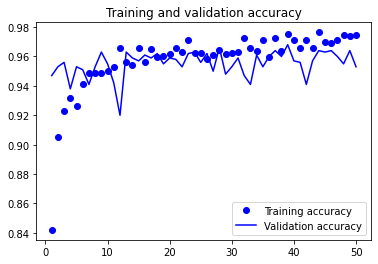

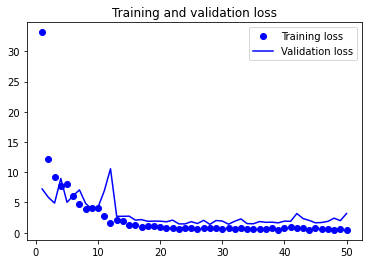

In [15]:
# Plot the loss and accuracy of the model over the training and validation data during training. 
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
# Display the accuracy of the model on the test dataset
test_model = keras.models.load_model('models/feature_extraction_with_data_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

63/63 [==============================] - 8s 119ms/step - loss: 1.4005 - accuracy: 0.9630
Test accuracy: 0.963


## Fine Tuning a Pretrained Model

In [17]:
# Unfreeze the top four layers
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
  layer.trainable = False

In [18]:
# Recompile the model (since we changed the trainable layers)
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=['accuracy'])


In [19]:
# Define callbacks again, with a new save file
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath='models/fine_tuning.keras',
    save_best_only=True,
    monitor='val_loss')]


In [20]:
start_time = time.time()

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

print("--- Model trained in %s seconds ---" % (time.time() - start_time))

Epoch 1/30
63/63 [==============================] - 14s 203ms/step - loss: 0.8980 - accuracy: 0.9719 - val_loss: 2.1612 - val_accuracy: 0.9650
Epoch 2/30
63/63 [==============================] - 13s 203ms/step - loss: 0.6651 - accuracy: 0.9750 - val_loss: 1.9518 - val_accuracy: 0.9660
Epoch 3/30
63/63 [==============================] - 13s 203ms/step - loss: 0.4673 - accuracy: 0.9766 - val_loss: 1.8423 - val_accuracy: 0.9600
Epoch 4/30
63/63 [==============================] - 13s 202ms/step - loss: 0.2876 - accuracy: 0.9879 - val_loss: 1.8155 - val_accuracy: 0.9590
Epoch 5/30
63/63 [==============================] - 13s 201ms/step - loss: 0.3952 - accuracy: 0.9801 - val_loss: 1.9527 - val_accuracy: 0.9630
Epoch 6/30
63/63 [==============================] - 13s 203ms/step - loss: 0.2278 - accuracy: 0.9851 - val_loss: 1.9801 - val_accuracy: 0.9630
Epoch 7/30
63/63 [==============================] - 13s 201ms/step - loss: 0.2628 - accuracy: 0.9869 - val_loss: 1.9832 - val_accuracy: 0.9610

In [21]:
# Display the accuracy of the model on the test dataset
model = keras.models.load_model('models/fine_tuning.keras')
test_loss, test_acc = model.evaluate(test_dataset)
print('Test accuracy: %.3f' % (test_acc,))

63/63 [==============================] - 8s 119ms/step - loss: 1.5694 - accuracy: 0.9650
Test accuracy: 0.965
